# QML on IBM Computers with [PennyLane](https://pennylane.ai/qml/demos/ibm_pennylane) 

IBM offers access to a variety of devices, both classical simulators and real quantum hardware. By default, these devices are not included in PennyLane, but after installing the [PennyLane-Qiskit](https://docs.pennylane.ai/projects/qiskit/en/stable/) plugin with the command pip install pennylane-qiskit, they can be used just like any other device offered in PennyLane!

**When running on Colab, we need to start by installing the dependencies. 

In [1]:
! pip install pennylane-qiskit qiskit pennylane matplotlib tqdm

Currently, there are three devices available — Aer, BasicSim and Remote — that can be initialized as follows:

In [46]:
import pennylane as qml
from qiskit_aer import AerSimulator

dev = qml.device("qiskit.aer", wires=1, backendbackend=AerSimulator())

### Listing out our backends

In [23]:
from qiskit_aer import Aer

print(Aer.backends())

[AerSimulator('aer_simulator'), AerSimulator('aer_simulator_statevector'), AerSimulator('aer_simulator_density_matrix'), AerSimulator('aer_simulator_stabilizer'), AerSimulator('aer_simulator_matrix_product_state'), AerSimulator('aer_simulator_extended_stabilizer'), AerSimulator('aer_simulator_unitary'), AerSimulator('aer_simulator_superop'), QasmSimulator('qasm_simulator'), StatevectorSimulator('statevector_simulator'), UnitarySimulator('unitary_simulator')]


## Creating your first circuit!! 
Every circuit in pennylane is a python function wrapped in a [Pennylane Qnode](https://docs.pennylane.ai/en/stable/code/api/pennylane.QNode.html). By default every qubit is initialized to the $\ket{0}$ state. Lets start by creating a simple circuit to flip the qubit state.

In [47]:
@qml.qnode(dev)
def flipper():
    qml.X(wires=0) # We apply the Pauli-X gate on the first qubit
    return qml.probs() # Return the probabilities of the circuit

In [48]:
flipper()

/home/vinayak/miniconda3/envs/QML/lib/python3.12/site-packages/pennylane_qiskit/qiskit_device_legacy.py:143: UserWarning: The analytic calculation of expectations, variances and probabilities is only supported on statevector backends, not on the aer_simulator. Such statistics obtained from this device are estimates based on samples.
  warnings.warn(self.analytic_warning_message.format(self.backend_name), UserWarning)


array([0., 1.])

We can visualize these circuits as well using the [`qml.draw_mpl`](https://docs.pennylane.ai/en/stable/code/api/pennylane.draw_mpl.html) function.

(<Figure size 400x200 with 1 Axes>, <Axes: >)

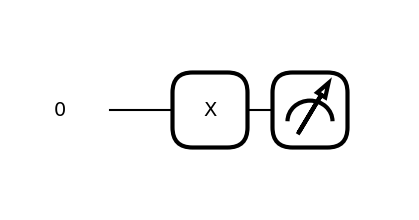

In [35]:
qml.draw_mpl(flipper)()

### Lets add some classical variables here
Pennylane allows us to pass arguments to qnodes just like normal python functions !

Let's create a Qnode which takes a boolean x as an input and flips the qubit state based on this boolean. This is also known as [basis state encoding](https://pennylane.ai/qml/glossary/quantum_embedding).

In [36]:
@qml.qnode(dev)
def flipper2(x:bool):
    if(x):
        qml.X(0)
    return qml.probs()

In [37]:
flipper2(True)

/home/vinayak/miniconda3/envs/QML/lib/python3.12/site-packages/pennylane_qiskit/qiskit_device_legacy.py:143: UserWarning: The analytic calculation of expectations, variances and probabilities is only supported on statevector backends, not on the aer_simulator. Such statistics obtained from this device are estimates based on samples.
  warnings.warn(self.analytic_warning_message.format(self.backend_name), UserWarning)


array([0., 1.])

In [38]:
flipper2(False)

array([1., 0.])

### More Gates More Compute !
Lets now create the circuit which applies the `H`, `Z` and `X` gates in that order. We should expect the state :

In [40]:
@qml.qnode(dev)
def multiple_gates():
    qml.Hadamard(0)
    qml.Z(0)
    qml.X(0)
    return qml.probs()

In [42]:
multiple_gates()

array([0.4765625, 0.5234375])

(<Figure size 600x200 with 1 Axes>, <Axes: >)

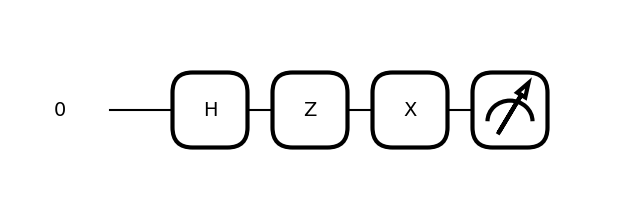

In [43]:
qml.draw_mpl(multiple_gates)()

## Moving to Multiple Qubits

Lets create a circuit to create the Bell $\ket{\phi_+}$-state.

We do it the following order:
1. Create a new device with 2 qubits
2. Apply the gates to the appropriate qubits
3. Return the probs

In [52]:
dev = qml.device("qiskit.aer", wires=2, backendbackend=AerSimulator())

In [53]:
@qml.qnode(dev)
def bell_maker():
    qml.Hadamard(0)
    qml.CNOT([0,1])
    return qml.probs()

In [54]:
bell_maker()

array([0.50195312, 0.        , 0.        , 0.49804688])

(<Figure size 500x300 with 1 Axes>, <Axes: >)

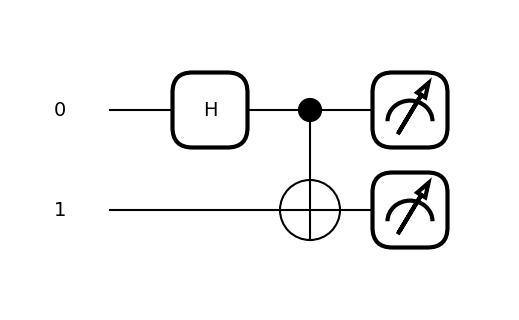

In [56]:
qml.draw_mpl(bell_maker)()

# Quantum Machine Learning

Quantum Machine Learning 

In [62]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [88]:
dev = qml.device("lightning.qubit", wires=2)

## Data Generation
Our dataset is generated by creating a random quantum circuit in 1 variable (x) which then produce a resultant measurement expval on the Pauli-Z observable (computational basis state). 

*tf;dr* Create a random gate and then measure the expectation value of the state

In [76]:
@qml.qnode(dev)
def data_gen(x,weights):
    qml.RY(x,wires=0)
    qml.RandomLayers(weights,wires=0,ratio_imprim=0.4)
    return qml.expval(qml.Z(0))    

In [77]:
w = np.random.randn(3,1)

Visualizing the Circuit

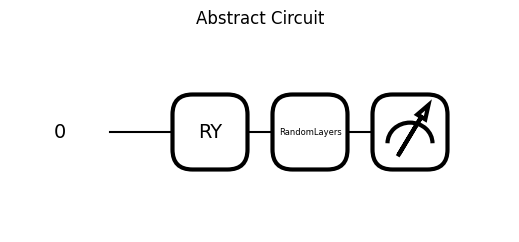

In [79]:
fig = qml.draw_mpl(data_gen)(np.random.randn(),w)
t = plt.title("Abstract Circuit")

Making it more clear to see

/home/vinayak/miniconda3/envs/QML/lib/python3.12/site-packages/pennylane_qiskit/qiskit_device_legacy.py:143: UserWarning: The analytic calculation of expectations, variances and probabilities is only supported on statevector backends, not on the aer_simulator. Such statistics obtained from this device are estimates based on samples.
  warnings.warn(self.analytic_warning_message.format(self.backend_name), UserWarning)


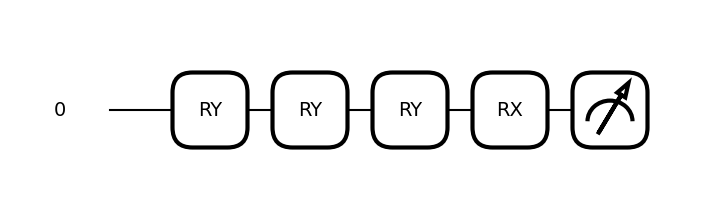

In [80]:
fig = qml.draw_mpl(data_gen,level='device')(np.random.randn(),w)

### Making a dataset out of the circuit

In [84]:
from tqdm import tqdm

In [86]:
n_points = 500
x = np.random.randn(n_points).astype(np.float32)
labels = []
weights = np.random.randn(3,1).astype(np.float32)
for i in tqdm(range(n_points)):
    labels.append(np.sign(data_gen(i,weights)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.67it/s]


In [ ]:
for label in set(labels):
    x_subset = [x_i for i, x_i in enumerate(x) if labels[i] == label]
    y_subset = [y_i for i, y_i in enumerate(y) if labels[i] == label]
    marker = 'v' if label == -1.0 else 'x'  # Example markers: 'o' for circles, 'x' for crosses
    plt.scatter(x_subset, y_subset, label=label, marker=marker)

# Add labels, title, and legend
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('3 layer Randomly Generated 2-D Quantum Function dataset')
plt.savefig("Dataset.png")